# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

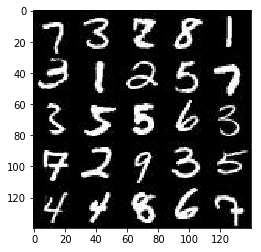

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

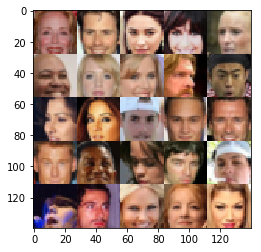

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                  name="input_real")
    z_data = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="lr")

    return input_images, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False))
        relu1 = tf.maximum(alpha * x1, x1)
        # 
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False))
        # bn2 = x2
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False))
        # bn3 = x3
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        shape = relu3.get_shape().as_list()
     
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    training = is_train
    output_dim = out_channel_dim
    reuse = False if is_train else True
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512, activation=None, use_bias=False,
                             kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid', use_bias=False,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False))
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', use_bias=False,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False))
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False))
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    output_dim = out_channel_dim
    g_model = generator(input_z, output_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_channels = 3 if data_image_mode == "RGB" else 1
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
        
    steps = 0
    samples, losses = [], []
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2

                # TODO: Train Model
                
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr : learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr : learning_rate})
                
                if steps % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/5... Discriminator Loss: 0.4298... Generator Loss: 7.1793


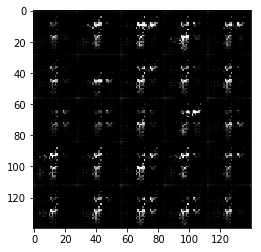

Epoch 1/5... Discriminator Loss: 0.6129... Generator Loss: 1.9274


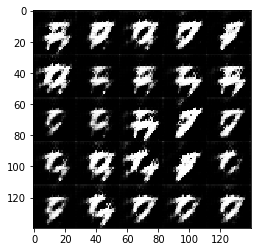

Epoch 1/5... Discriminator Loss: 0.5427... Generator Loss: 2.9321


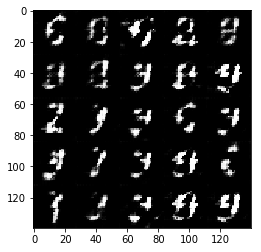

Epoch 1/5... Discriminator Loss: 0.8762... Generator Loss: 1.6678


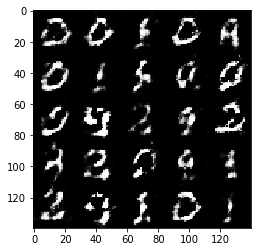

Epoch 2/5... Discriminator Loss: 0.9987... Generator Loss: 1.1326


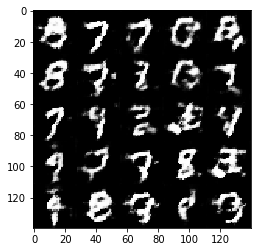

Epoch 2/5... Discriminator Loss: 0.8900... Generator Loss: 1.2459


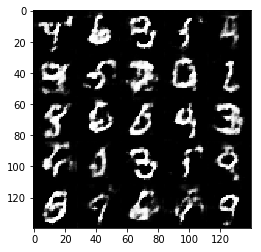

Epoch 2/5... Discriminator Loss: 0.9344... Generator Loss: 1.2556


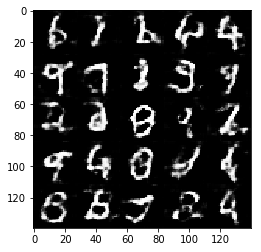

Epoch 2/5... Discriminator Loss: 1.0922... Generator Loss: 2.2150


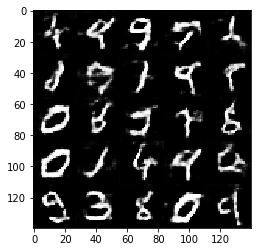

Epoch 2/5... Discriminator Loss: 1.3885... Generator Loss: 2.7762


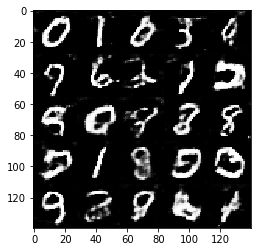

Epoch 3/5... Discriminator Loss: 0.9386... Generator Loss: 1.0812


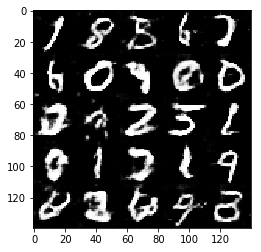

Epoch 3/5... Discriminator Loss: 0.7616... Generator Loss: 1.7505


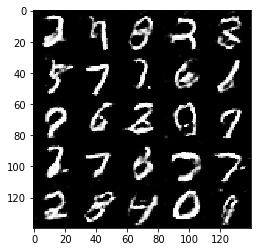

Epoch 3/5... Discriminator Loss: 0.8448... Generator Loss: 1.4333


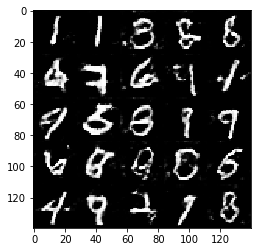

Epoch 3/5... Discriminator Loss: 1.0500... Generator Loss: 1.0047


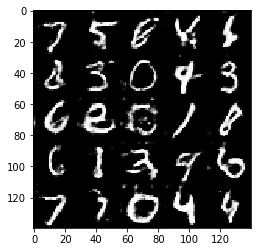

Epoch 3/5... Discriminator Loss: 1.7832... Generator Loss: 0.3866


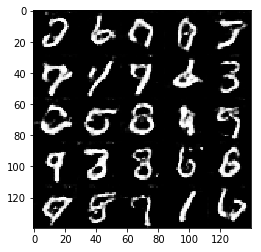

Epoch 4/5... Discriminator Loss: 1.0009... Generator Loss: 1.9942


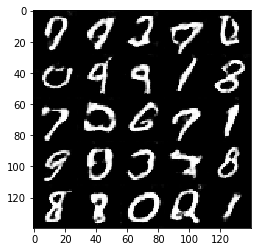

Epoch 4/5... Discriminator Loss: 1.2291... Generator Loss: 0.7530


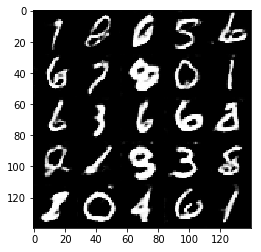

Epoch 4/5... Discriminator Loss: 1.8555... Generator Loss: 0.3300


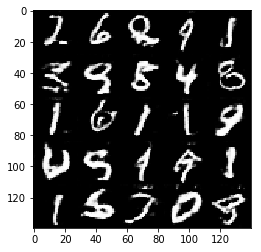

Epoch 4/5... Discriminator Loss: 1.0444... Generator Loss: 1.1546


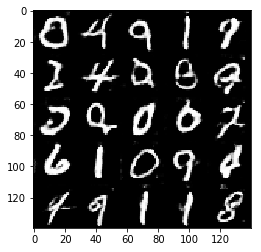

Epoch 5/5... Discriminator Loss: 0.9861... Generator Loss: 1.1211


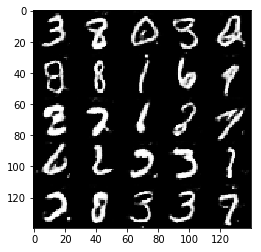

Epoch 5/5... Discriminator Loss: 1.7276... Generator Loss: 3.8715


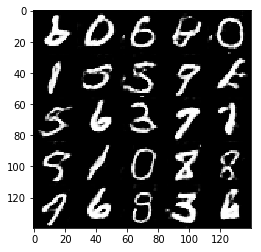

Epoch 5/5... Discriminator Loss: 0.9912... Generator Loss: 0.9488


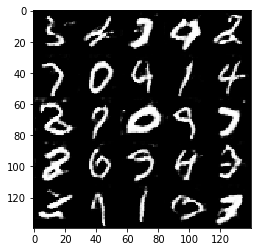

Epoch 5/5... Discriminator Loss: 0.7855... Generator Loss: 1.2633


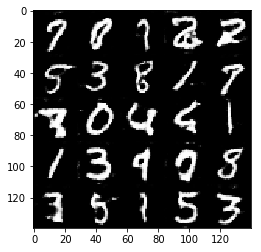

Epoch 5/5... Discriminator Loss: 1.0619... Generator Loss: 0.8396


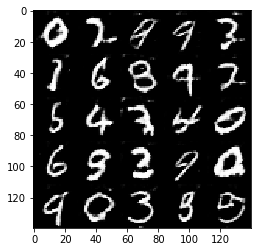

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
alpha = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/25... Discriminator Loss: 0.5102... Generator Loss: 2.6968


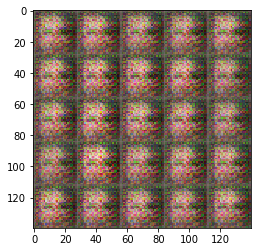

Epoch 1/25... Discriminator Loss: 0.6686... Generator Loss: 1.7481


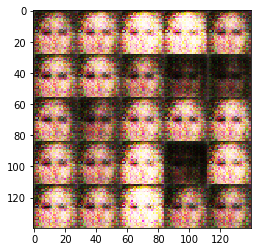

Epoch 1/25... Discriminator Loss: 0.5724... Generator Loss: 2.2990


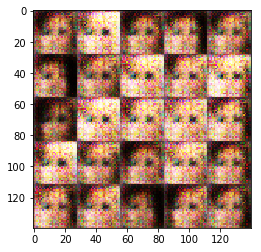

Epoch 1/25... Discriminator Loss: 0.8719... Generator Loss: 1.9434


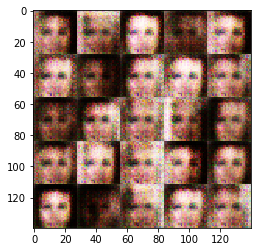

Epoch 1/25... Discriminator Loss: 0.8132... Generator Loss: 1.7274


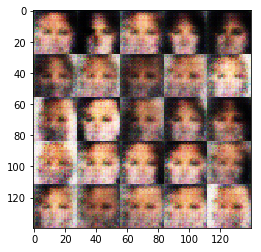

Epoch 1/25... Discriminator Loss: 1.1447... Generator Loss: 1.1059


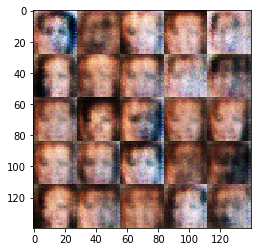

Epoch 1/25... Discriminator Loss: 0.8563... Generator Loss: 1.6287


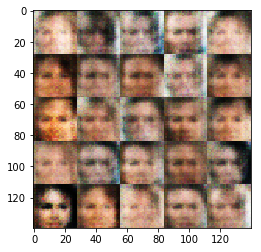

Epoch 2/25... Discriminator Loss: 0.9228... Generator Loss: 1.6482


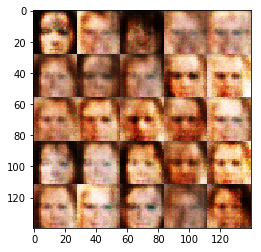

Epoch 2/25... Discriminator Loss: 0.9000... Generator Loss: 1.5442


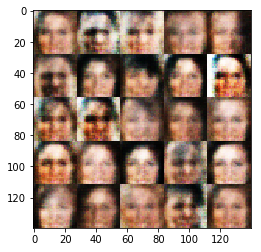

Epoch 2/25... Discriminator Loss: 1.1602... Generator Loss: 1.7177


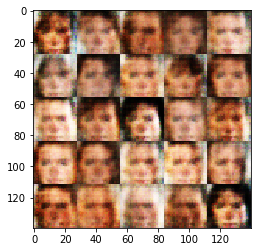

Epoch 2/25... Discriminator Loss: 0.9419... Generator Loss: 1.5007


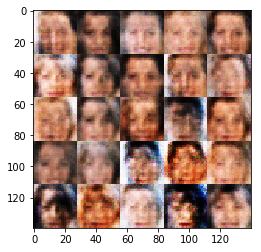

Epoch 2/25... Discriminator Loss: 0.9587... Generator Loss: 1.0644


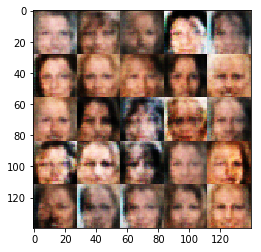

Epoch 2/25... Discriminator Loss: 1.0765... Generator Loss: 1.2305


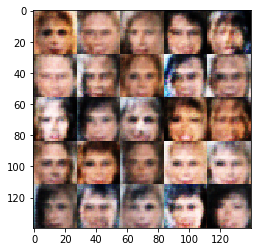

Epoch 2/25... Discriminator Loss: 0.9511... Generator Loss: 1.3147


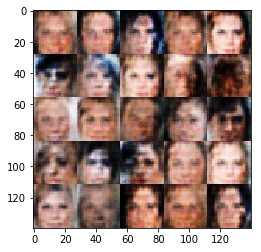

Epoch 2/25... Discriminator Loss: 1.2902... Generator Loss: 0.6672


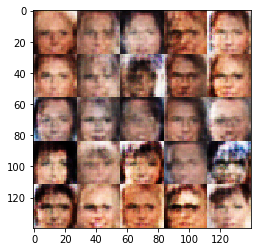

Epoch 3/25... Discriminator Loss: 1.0593... Generator Loss: 1.2706


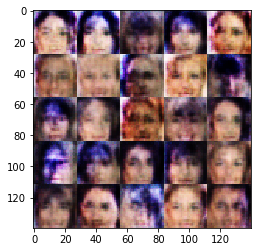

Epoch 3/25... Discriminator Loss: 0.9777... Generator Loss: 1.5279


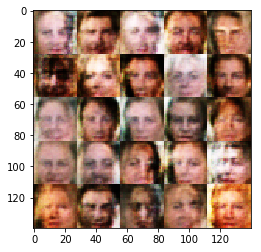

Epoch 3/25... Discriminator Loss: 0.8821... Generator Loss: 1.4998


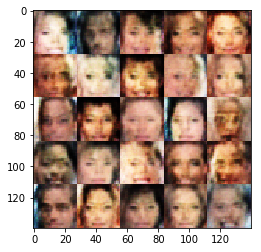

Epoch 3/25... Discriminator Loss: 1.3157... Generator Loss: 2.2056


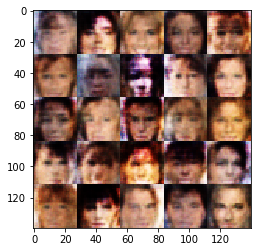

Epoch 3/25... Discriminator Loss: 1.2710... Generator Loss: 0.6800


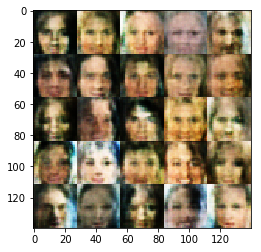

Epoch 3/25... Discriminator Loss: 1.0485... Generator Loss: 1.1034


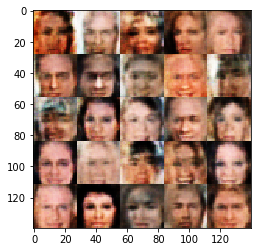

Epoch 3/25... Discriminator Loss: 1.0776... Generator Loss: 1.2567


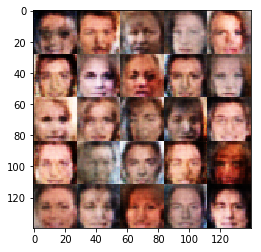

Epoch 3/25... Discriminator Loss: 0.8813... Generator Loss: 1.5623


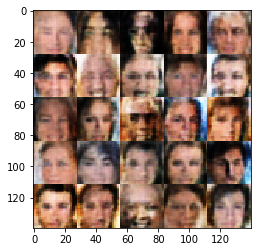

Epoch 4/25... Discriminator Loss: 1.1022... Generator Loss: 0.8639


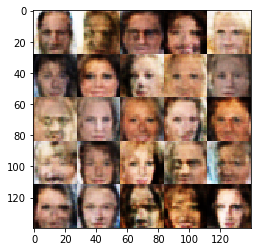

Epoch 4/25... Discriminator Loss: 1.0133... Generator Loss: 1.4924


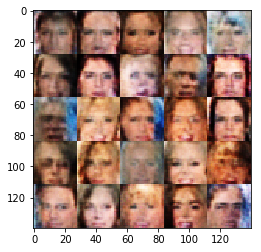

Epoch 4/25... Discriminator Loss: 1.1652... Generator Loss: 0.8064


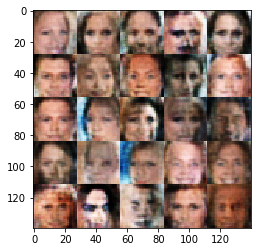

Epoch 4/25... Discriminator Loss: 1.0916... Generator Loss: 0.8693


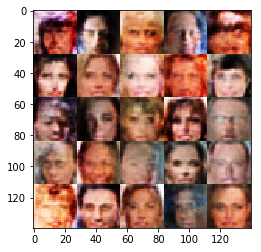

Epoch 4/25... Discriminator Loss: 0.9896... Generator Loss: 1.5657


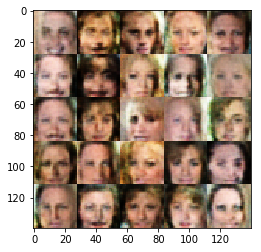

Epoch 4/25... Discriminator Loss: 1.0298... Generator Loss: 1.0391


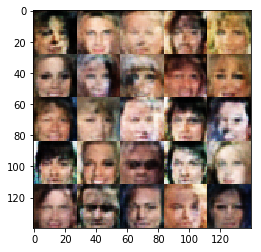

Epoch 4/25... Discriminator Loss: 0.9597... Generator Loss: 1.3100


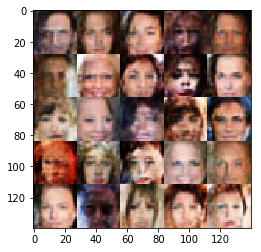

Epoch 4/25... Discriminator Loss: 1.0603... Generator Loss: 1.1212


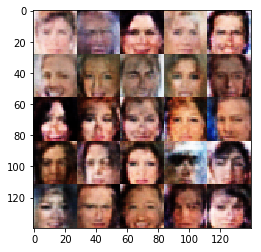

Epoch 5/25... Discriminator Loss: 1.0173... Generator Loss: 1.1989


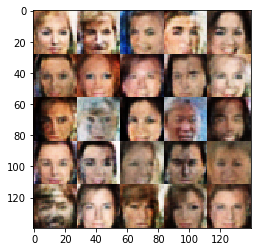

Epoch 5/25... Discriminator Loss: 0.9485... Generator Loss: 0.9968


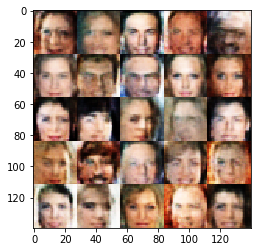

Epoch 5/25... Discriminator Loss: 0.9451... Generator Loss: 1.0916


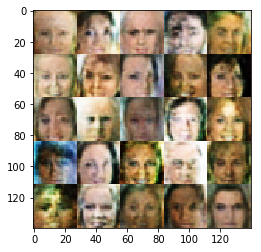

Epoch 5/25... Discriminator Loss: 1.0485... Generator Loss: 1.0183


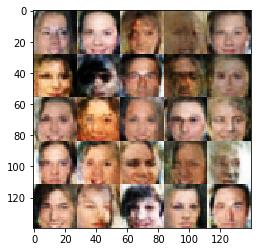

Epoch 5/25... Discriminator Loss: 0.9659... Generator Loss: 1.3139


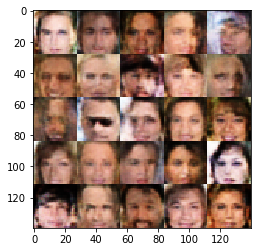

Epoch 5/25... Discriminator Loss: 1.0380... Generator Loss: 1.0227


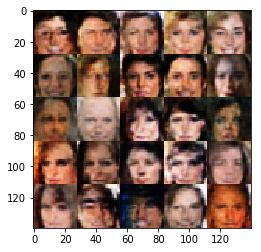

Epoch 5/25... Discriminator Loss: 1.0094... Generator Loss: 1.6861


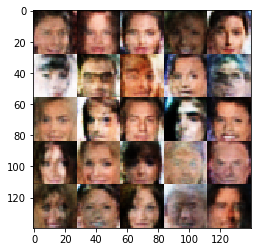

Epoch 5/25... Discriminator Loss: 0.9215... Generator Loss: 1.2743


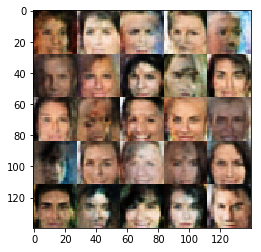

Epoch 6/25... Discriminator Loss: 0.8983... Generator Loss: 1.0230


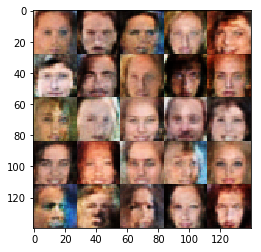

Epoch 6/25... Discriminator Loss: 0.9611... Generator Loss: 1.1550


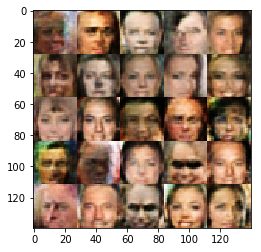

Epoch 6/25... Discriminator Loss: 0.9828... Generator Loss: 1.2750


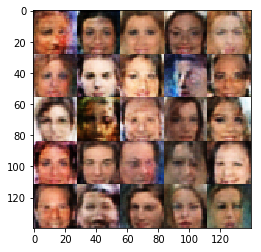

Epoch 6/25... Discriminator Loss: 0.9746... Generator Loss: 1.0229


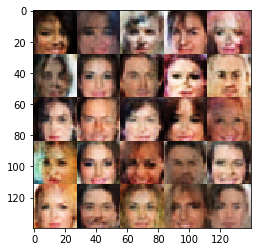

Epoch 6/25... Discriminator Loss: 0.9760... Generator Loss: 1.1404


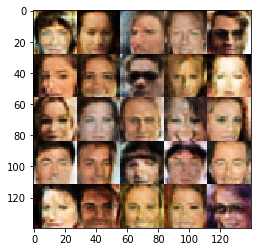

Epoch 6/25... Discriminator Loss: 1.0988... Generator Loss: 1.5144


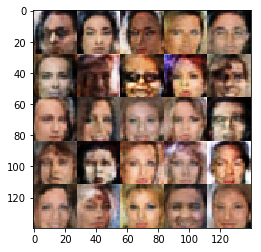

Epoch 6/25... Discriminator Loss: 0.9559... Generator Loss: 1.3685


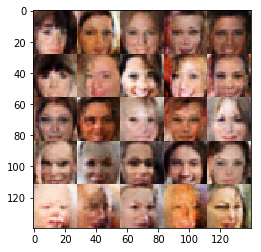

Epoch 6/25... Discriminator Loss: 1.0134... Generator Loss: 1.7706


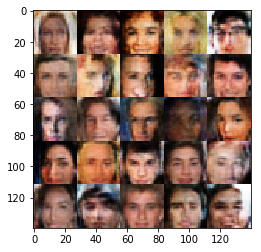

Epoch 7/25... Discriminator Loss: 1.1047... Generator Loss: 0.7958


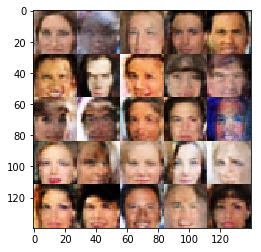

Epoch 7/25... Discriminator Loss: 1.0280... Generator Loss: 1.0646


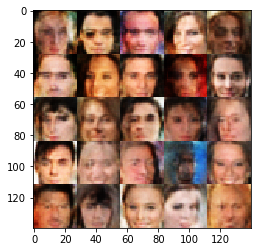

Epoch 7/25... Discriminator Loss: 1.1673... Generator Loss: 1.9267


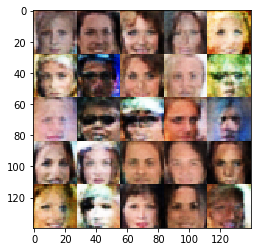

Epoch 7/25... Discriminator Loss: 1.1021... Generator Loss: 0.8391


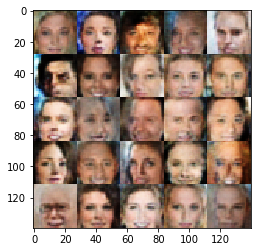

Epoch 7/25... Discriminator Loss: 1.1094... Generator Loss: 0.8244


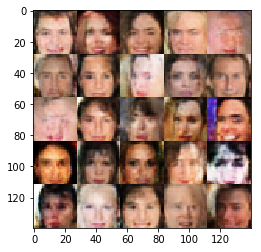

Epoch 7/25... Discriminator Loss: 0.9068... Generator Loss: 1.3673


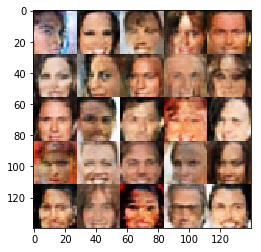

Epoch 7/25... Discriminator Loss: 1.0709... Generator Loss: 0.8782


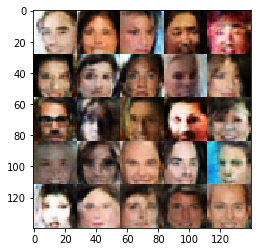

Epoch 7/25... Discriminator Loss: 0.8184... Generator Loss: 2.1078


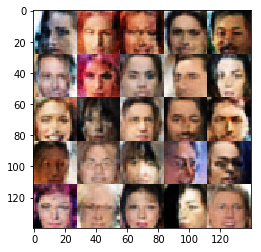

Epoch 8/25... Discriminator Loss: 1.0814... Generator Loss: 1.2382


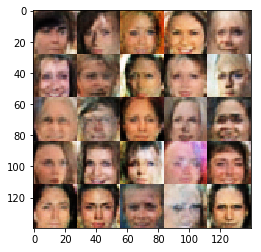

Epoch 8/25... Discriminator Loss: 0.9894... Generator Loss: 0.9962


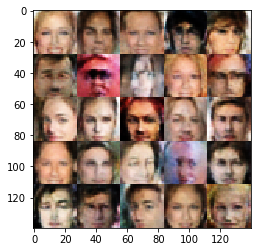

Epoch 8/25... Discriminator Loss: 0.9509... Generator Loss: 1.2706


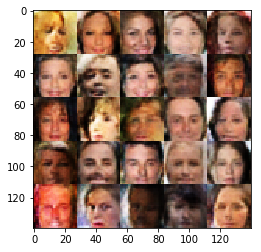

Epoch 8/25... Discriminator Loss: 1.0090... Generator Loss: 1.8978


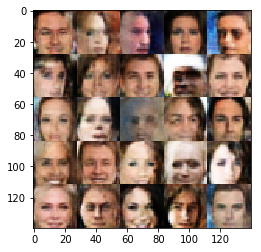

Epoch 8/25... Discriminator Loss: 1.1684... Generator Loss: 0.7436


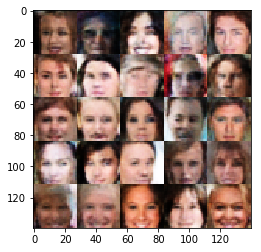

Epoch 8/25... Discriminator Loss: 1.0543... Generator Loss: 1.5349


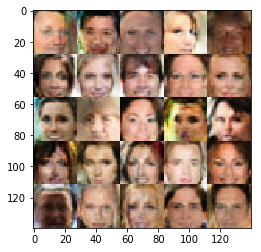

Epoch 8/25... Discriminator Loss: 0.9151... Generator Loss: 1.3306


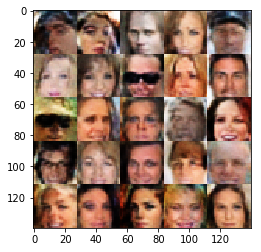

Epoch 8/25... Discriminator Loss: 0.9969... Generator Loss: 1.5541


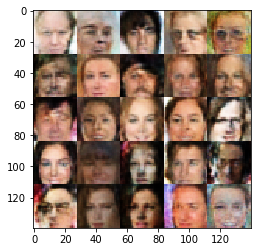

Epoch 9/25... Discriminator Loss: 0.9594... Generator Loss: 0.9887


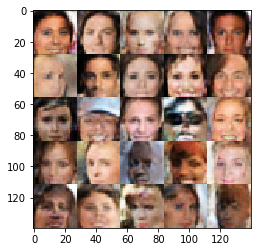

Epoch 9/25... Discriminator Loss: 1.0842... Generator Loss: 0.9733


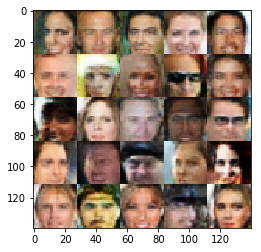

Epoch 9/25... Discriminator Loss: 1.0726... Generator Loss: 0.9053


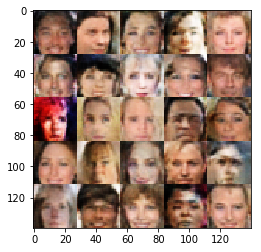

Epoch 9/25... Discriminator Loss: 0.8430... Generator Loss: 1.3464


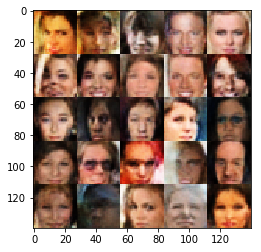

Epoch 9/25... Discriminator Loss: 1.0605... Generator Loss: 0.9852


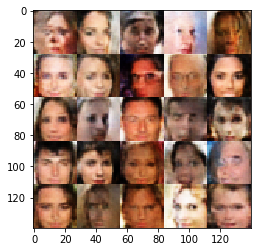

Epoch 9/25... Discriminator Loss: 1.0272... Generator Loss: 0.9400


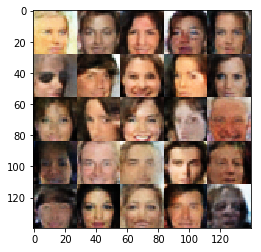

Epoch 9/25... Discriminator Loss: 0.9926... Generator Loss: 1.4335


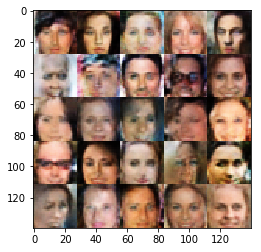

Epoch 9/25... Discriminator Loss: 1.0558... Generator Loss: 0.8508


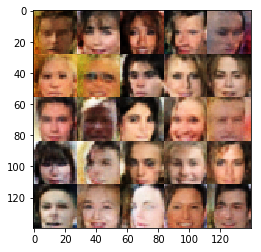

Epoch 10/25... Discriminator Loss: 0.8894... Generator Loss: 2.1735


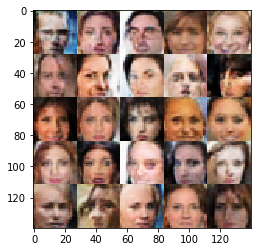

Epoch 10/25... Discriminator Loss: 0.9111... Generator Loss: 1.6013


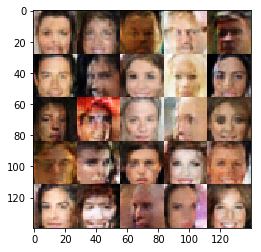

Epoch 10/25... Discriminator Loss: 0.9793... Generator Loss: 1.0906


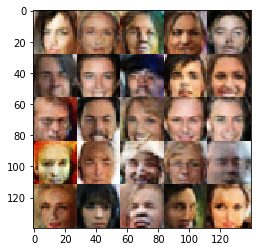

Epoch 10/25... Discriminator Loss: 1.3595... Generator Loss: 0.5326


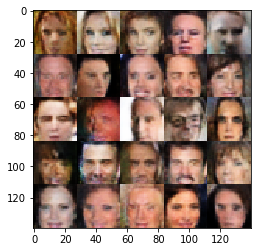

Epoch 10/25... Discriminator Loss: 0.9809... Generator Loss: 1.3754


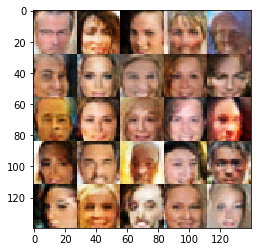

Epoch 10/25... Discriminator Loss: 1.0688... Generator Loss: 0.9737


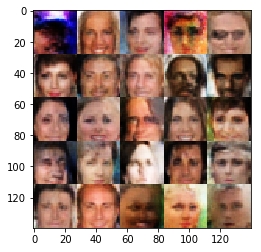

Epoch 10/25... Discriminator Loss: 1.0615... Generator Loss: 2.4182


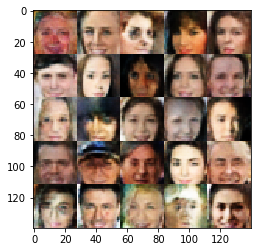

Epoch 10/25... Discriminator Loss: 0.9997... Generator Loss: 0.8855


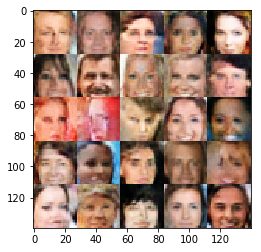

Epoch 11/25... Discriminator Loss: 0.9206... Generator Loss: 1.6203


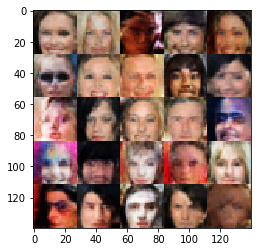

Epoch 11/25... Discriminator Loss: 0.9805... Generator Loss: 1.1317


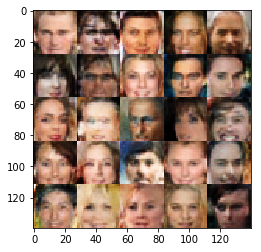

Epoch 11/25... Discriminator Loss: 1.0263... Generator Loss: 0.8624


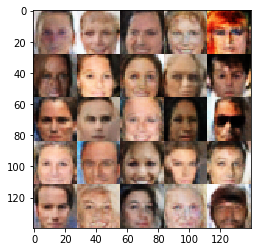

Epoch 11/25... Discriminator Loss: 1.0696... Generator Loss: 1.8842


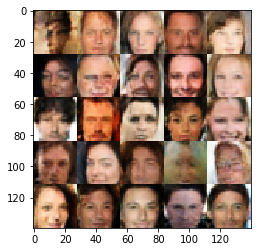

Epoch 11/25... Discriminator Loss: 0.9206... Generator Loss: 1.1514


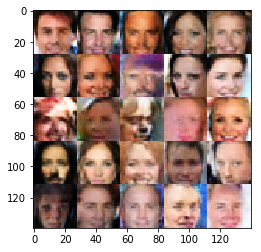

Epoch 11/25... Discriminator Loss: 1.0671... Generator Loss: 0.9627


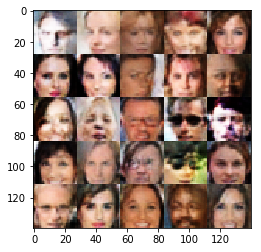

Epoch 11/25... Discriminator Loss: 1.1722... Generator Loss: 0.7352


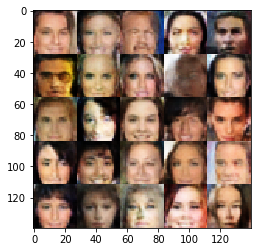

Epoch 11/25... Discriminator Loss: 0.9894... Generator Loss: 1.2461


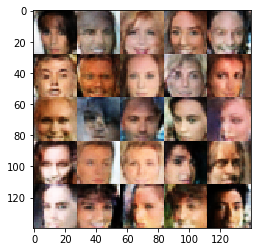

Epoch 12/25... Discriminator Loss: 0.8537... Generator Loss: 1.3074


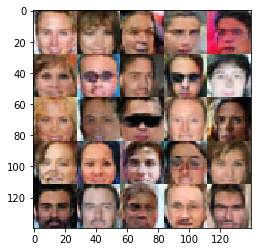

Epoch 12/25... Discriminator Loss: 1.2779... Generator Loss: 0.6380


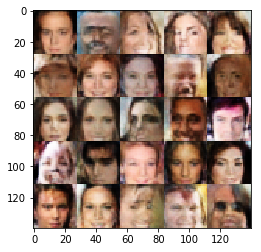

Epoch 12/25... Discriminator Loss: 0.9394... Generator Loss: 1.1098


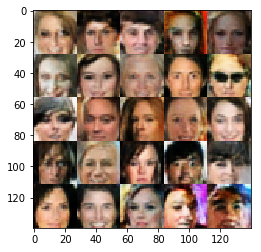

Epoch 12/25... Discriminator Loss: 0.9579... Generator Loss: 1.3495


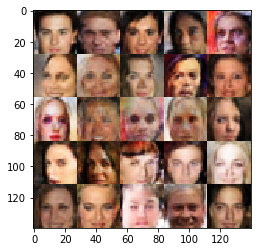

Epoch 12/25... Discriminator Loss: 0.9786... Generator Loss: 0.9356


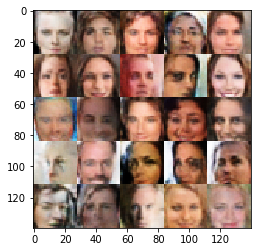

Epoch 12/25... Discriminator Loss: 0.8927... Generator Loss: 1.1782


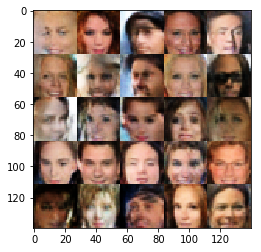

Epoch 12/25... Discriminator Loss: 0.9947... Generator Loss: 1.0081


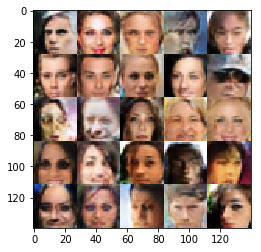

Epoch 13/25... Discriminator Loss: 1.0220... Generator Loss: 1.2010


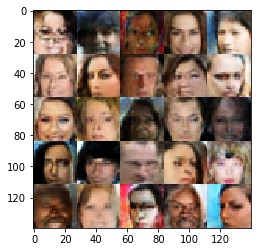

Epoch 13/25... Discriminator Loss: 1.0410... Generator Loss: 0.9851


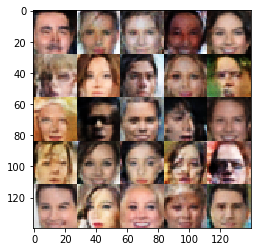

Epoch 13/25... Discriminator Loss: 1.1395... Generator Loss: 1.2194


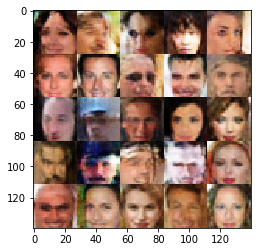

Epoch 13/25... Discriminator Loss: 0.8881... Generator Loss: 1.1739


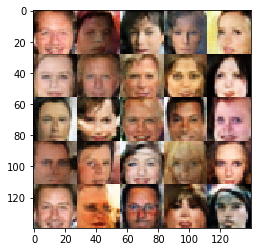

Epoch 13/25... Discriminator Loss: 0.9500... Generator Loss: 1.4542


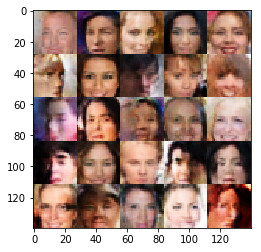

KeyboardInterrupt: 

In [15]:
batch_size = 256
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 25
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.